# GraphRAG

In [ ]:
import pandas as pd
import lancedb
from openai import AzureOpenAI
import dotenv
import os
from yfiles_jupyter_graphs import GraphWidget
from graphrag.query.indexer_adapters import read_indexer_entities, read_indexer_reports

from graphrag.query.structured_search.global_search.community_context import (
    GlobalCommunityContext,
)
from graphrag.query.structured_search.global_search.search import GlobalSearch

from graphrag.query.structured_search.local_search.mixed_context import (
    LocalSearchMixedContext,
)
from graphrag.query.structured_search.local_search.search import LocalSearch
from graphrag.vector_stores.lancedb import LanceDBVectorStore

from graphrag.query.context_builder.entity_extraction import EntityVectorStoreKey
from graphrag.query.indexer_adapters import (
    read_indexer_communities,
    read_indexer_covariates,
    read_indexer_entities,
    read_indexer_relationships,
    read_indexer_reports,
    read_indexer_text_units,
)

import numpy as np
import math

from graphrag.config.enums import ModelType
from graphrag.config.models.language_model_config import LanguageModelConfig
from graphrag.language_model.manager import ModelManager
import tiktoken

## Felhasznalt anyagok

https://github.com/ALucek/GraphRAG-Breakdown/blob/main/graph_examples.ipynb

graphrag init --root graphragtest

graphrag index --root graphragtest

https://microsoft.github.io/graphrag/index/default_dataflow/

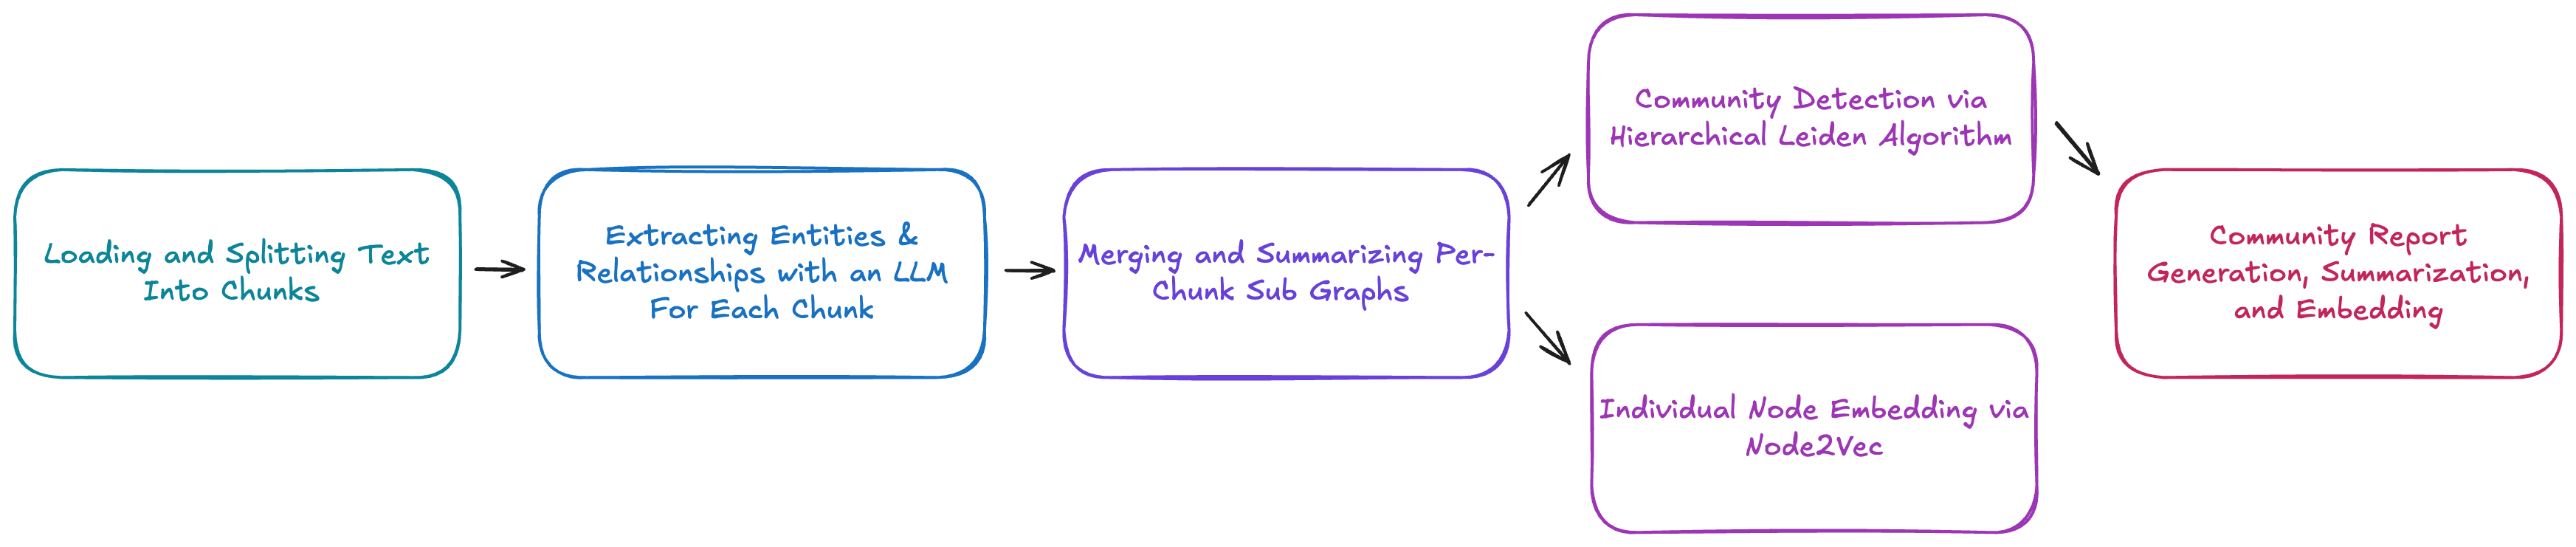

## Elokeszito kodok

In [ ]:
dotenv.load_dotenv("graphragtest/.env")

In [ ]:
chat_client = AzureOpenAI(
    azure_endpoint=os.getenv("AZURE_API_BASE"),
    api_version=os.getenv("AZURE_API_VERSION"),
    api_key=os.getenv("AZURE_API_KEY")
)

In [ ]:
embed_client = AzureOpenAI(
    azure_endpoint=os.getenv("AZURE_API_BASE_EMBED"),
    api_version=os.getenv("AZURE_API_VERSION_EMBED"),
    api_key=os.getenv("AZURE_API_KEY_EMBED")
)

In [ ]:
def get_embedding(text, model=os.getenv("AZURE_API_MODEL_EMBED")):
    response = embed_client.embeddings.create(
        input=text,
        model=model
    )
    return response.data[0].embedding

In [ ]:
def get_chat_response(context, prompt, model=os.getenv("AZURE_API_MODEL")):
    response = chat_client.chat.completions.create(
        model=model,
        messages=[
            {
                "role": "system", 
                "content": f"You are a helpful assistant answering questions based on context. \
                    If the context does not provide enough information to answer the question, you should say 'I don't know'. \
                    Context START \
                        {context} \
                    Context END"
            },
            {
                "role": "user", 
                "content": prompt
            }
        ]
    )
    return response.choices[0].message.content

In [ ]:
def list_lancedb_tables():
    try:
        db = lancedb.connect("./graphragtest/output/lancedb")
        tables = db.table_names()
        print("Available tables:")
        for table in tables:
            print(f"  - {table}")
        return tables
    except Exception as e:
        print(f"Error listing tables: {e}")
        return []

In [ ]:
def query_lancedb_vector(query_text, table_name, top_k=1):
    try:
        db = lancedb.connect("./graphragtest/output/lancedb")
        table = db.open_table(table_name)
        results = table.search(query_text).limit(top_k).to_pandas()
        return results
    except Exception as e:
        print(f"Error querying LanceDB: {e}")
        return None

In [ ]:
def lancedb_rag(query, top_k=1):
    embedding = get_embedding(query)
    results1 = query_lancedb_vector(embedding, 'default-entity-description', top_k=top_k)
    results2 = query_lancedb_vector(embedding, 'default-text_unit-text', top_k=top_k)
    results3 = query_lancedb_vector(embedding, 'default-community-full_content', top_k=top_k)
    results = pd.concat([results1, results2, results3], ignore_index=True)

    if results is not None and not results.empty:
        context = results.text
        print(len(context))
        print("-" * 25, "LanceDB RAG Response", "-" * 25)
        print(context)
        print("-" * 50)
        response = get_chat_response(context, query)
    else:
        response = "No results found in LanceDB."
    return response

## LanceDB teszt - Hagyomanyos RAG

In [ ]:
get_embedding('Who is the killer?')

In [ ]:
sarahs_partner_question = "Who is the partner of Detective Sarah Chen?"
cops_question = "Name the two cops who working on the case."
where_question = "Where did the murder happen?"
evidence_question = 'What are the key evidences in the Gallery of Secrets story?'
motive_question = "What is the motive behind the murder?"
weapon_question = "Where did the killer hide the murder weapon?"
killer_question = "Who is the killer?"
questions = [sarahs_partner_question, cops_question, where_question, evidence_question, motive_question, weapon_question, killer_question]

### RAG nelkul

In [ ]:
for question in questions:
    print('='*50)
    print(question)
    print('-'*50)
    print(get_chat_response(None, question))
    print(' '*50)

In [ ]:
available_tables = list_lancedb_tables()

### Entity level

In [ ]:
for question in questions:
    results = query_lancedb_vector(get_embedding(question), 'default-entity-description', top_k=10)
    print('='*50)
    print(question)
    print('-'*50)
    print(results.text)
    print('-'*50)
    print(get_chat_response(results.text, question))
    print(' '*50)

### Community level

In [ ]:
for question in questions:
    results = query_lancedb_vector(get_embedding(question), 'default-community-full_content', top_k=10)
    print('='*50)
    print(question)
    print('-'*50)
    print(results.text)
    print('-'*50)
    print(get_chat_response(results.text, question))
    print(' '*50)

### Text level

In [ ]:
for question in questions:
    results = query_lancedb_vector(get_embedding(question), 'default-text_unit-text', top_k=10)
    print('='*50)
    print(question)
    print('-'*50)
    print(results.text)
    print('-'*50)
    print(get_chat_response(results.text, question))
    print(' '*50)

### Mind a harom egyben

In [ ]:
for question in questions:
    print('='*50)
    print(question)
    print('-'*50)
    print(lancedb_rag(question, top_k=3))
    print(' '*50)

## Graf adatok vizsgalata

In [ ]:
pd.read_parquet('./graphragtest/output/documents.parquet').head()

In [ ]:
pd.read_parquet('./graphragtest/output/entities.parquet').head()

In [ ]:
pd.read_parquet('./graphragtest/output/relationships.parquet').head()

In [ ]:
pd.read_parquet('./graphragtest/output/text_units.parquet').head()

In [ ]:
pd.read_parquet('./graphragtest/output/communities.parquet').head()

In [ ]:
pd.read_parquet('./graphragtest/output/community_reports.parquet').head()

## Command line hasznalata

In [ ]:
!graphrag query --root ./graphragtest --method local --query "Explain the story's timeline."

In [ ]:
!graphrag query --root ./graphragtest --method global --query "Explain the story's timeline."

## Elokeszito kodok

In [ ]:
INPUT_DIR = "./graphragtest/output"
LANCEDB_URI = f"{INPUT_DIR}/lancedb"
COMMUNITY_REPORT_TABLE = "community_reports"
COMMUNITY_TABLE = "communities"
ENTITY_TABLE = "entities"
RELATIONSHIP_TABLE = "relationships"
COVARIATE_TABLE = "covariates"
TEXT_UNIT_TABLE = "text_units"
COMMUNITY_LEVEL = 2

In [ ]:
api_key = os.environ["AZURE_API_KEY"]
llm_model = os.environ["AZURE_API_MODEL"]
emb_model = os.environ["AZURE_API_MODEL_EMBED"]
api_base=os.environ["AZURE_API_BASE"]
api_version=os.environ["AZURE_API_VERSION"]
emb_api_version=os.environ["AZURE_API_VERSION_EMBED"]
token_encoder = tiktoken.get_encoding('o200k_base')

In [ ]:
entity_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_TABLE}.parquet")
community_df = pd.read_parquet(f"{INPUT_DIR}/{COMMUNITY_TABLE}.parquet")
relationship_df = pd.read_parquet(f"{INPUT_DIR}/{RELATIONSHIP_TABLE}.parquet")
report_df = pd.read_parquet(f"{INPUT_DIR}/{COMMUNITY_REPORT_TABLE}.parquet")
text_unit_df = pd.read_parquet(f"{INPUT_DIR}/{TEXT_UNIT_TABLE}.parquet")

communities = read_indexer_communities(community_df, report_df)
entities = read_indexer_entities(entity_df, community_df, COMMUNITY_LEVEL)
relationships = read_indexer_relationships(relationship_df)
reports = read_indexer_reports(report_df, community_df, COMMUNITY_LEVEL)
text_units = read_indexer_text_units(text_unit_df)

description_embedding_store = LanceDBVectorStore(
    collection_name="default-entity-description",
)
description_embedding_store.connect(db_uri=LANCEDB_URI)

In [ ]:
# converts the entities dataframe to a list of dicts for yfiles-jupyter-graphs
def convert_entities_to_dicts(df):
    """Convert the entities dataframe to a list of dicts for yfiles-jupyter-graphs."""
    
    def clean_value(value):
        """Clean values to be JSON serializable."""
        if isinstance(value, np.ndarray):
            return value.tolist()
        elif isinstance(value, (np.floating, float)):
            if np.isnan(value) or np.isinf(value) or not math.isfinite(value):
                return 0.0  # Replace invalid floats with 0
            return float(value)
        elif isinstance(value, (np.integer, int)):
            return int(value)
        elif isinstance(value, list):
            return [clean_value(item) for item in value]
        elif hasattr(value, 'dtype'):  # Handle other numpy types
            return clean_value(value.item())
        elif isinstance(value, str):
            return str(value)
        else:
            return value
    
    nodes_dict = {}
    for _, row in df.iterrows():
        # Create a dictionary for each row and collect unique nodes
        node_id = str(row["title"])  # Ensure string
        if node_id not in nodes_dict:
            # Clean the properties to ensure JSON compatibility
            properties = {}
            for key, value in row.to_dict().items():
                try:
                    cleaned_value = clean_value(value)
                    properties[str(key)] = cleaned_value
                except Exception as e:
                    print(f"Warning: Could not clean value for key {key}: {value} - {e}")
                    properties[str(key)] = str(value)  # Fallback to string
            
            nodes_dict[node_id] = {
                "id": node_id,
                "properties": properties,
            }
    return list(nodes_dict.values())


# converts the relationships dataframe to a list of dicts for yfiles-jupyter-graphs
def convert_relationships_to_dicts(df):
    """Convert the relationships dataframe to a list of dicts for yfiles-jupyter-graphs."""
    
    def clean_value(value):
        """Clean values to be JSON serializable."""
        if isinstance(value, np.ndarray):
            return value.tolist()
        elif isinstance(value, (np.floating, float)):
            if np.isnan(value) or np.isinf(value) or not math.isfinite(value):
                return 0.0  # Replace invalid floats with 0
            return float(value)
        elif isinstance(value, (np.integer, int)):
            return int(value)
        elif isinstance(value, list):
            return [clean_value(item) for item in value]
        elif hasattr(value, 'dtype'):  # Handle other numpy types
            return clean_value(value.item())
        elif isinstance(value, str):
            return str(value)
        else:
            return value
    
    relationships = []
    for _, row in df.iterrows():
        # Create a dictionary for each row
        properties = {}
        for key, value in row.to_dict().items():
            try:
                cleaned_value = clean_value(value)
                properties[str(key)] = cleaned_value
            except Exception as e:
                print(f"Warning: Could not clean value for key {key}: {value} - {e}")
                properties[str(key)] = str(value)  # Fallback to string
            
        relationships.append({
            "start": str(row["source"]),
            "end": str(row["target"]),
            "properties": properties,
        })
    return relationships


# Check for problematic values before creating the widget
print("Checking entity_df for problematic values...")
for col in entity_df.columns:
    if entity_df[col].dtype in ['float64', 'float32']:
        invalid_count = entity_df[col].isnull().sum() + np.isinf(entity_df[col]).sum()
        if invalid_count > 0:
            print(f"Column {col} has {invalid_count} invalid values")

print("Checking relationship_df for problematic values...")
for col in relationship_df.columns:
    if relationship_df[col].dtype in ['float64', 'float32']:
        invalid_count = relationship_df[col].isnull().sum() + np.isinf(relationship_df[col]).sum()
        if invalid_count > 0:
            print(f"Column {col} has {invalid_count} invalid values")

w = GraphWidget()
w.directed = True
w.nodes = convert_entities_to_dicts(entity_df)
w.edges = convert_relationships_to_dicts(relationship_df)
print("GraphWidget created successfully!")

In [ ]:
# Add a simple community assignment based on entity type
type_to_community = {}
unique_types = entity_df['type'].unique()
for i, entity_type in enumerate(unique_types):
    type_to_community[entity_type] = i

# Add community information to entity data based on type
for node in w.nodes:
    entity_type = node['properties'].get('type', 'UNKNOWN')
    node['properties']['community'] = type_to_community.get(entity_type, 0)

# show title on the node
w.node_label_mapping = "title"

# map community to a color
def community_to_color(community):
    """Map a community to a color."""
    colors = [
        "crimson",
        "darkorange", 
        "indigo",
        "cornflowerblue",
        "cyan",
        "teal",
        "green",
        "purple",
        "brown",
        "pink"
    ]
    if community is None:
        return "lightgray"
    return colors[int(community) % len(colors)]

def edge_to_source_community(edge):
    """Get the community of the source node of an edge."""
    source_node = next(
        (entry for entry in w.nodes if entry["properties"]["title"] == edge["start"]),
        None,
    )
    if source_node and "community" in source_node["properties"]:
        source_node_community = source_node["properties"]["community"]
        return source_node_community
    return None

w.node_color_mapping = lambda node: community_to_color(node["properties"].get("community"))
w.edge_color_mapping = lambda edge: community_to_color(edge_to_source_community(edge))

# map size data to a reasonable factor - use degree since there's no 'size' in entity_df
w.node_scale_factor_mapping = lambda node: 0.5 + node["properties"].get("degree", 1) * 1.5 / 20

# use weight for edge thickness but make edges thinner by scaling down
w.edge_thickness_factor_mapping = lambda edge: edge["properties"].get("weight", 1) * 0.05

print(f"Assigned communities based on entity types:")
for entity_type, community in type_to_community.items():
    print(f"  {entity_type} -> Community {community}")
print(f"\nTotal entities: {len(w.nodes)}")
print(f"Total edges: {len(w.edges)}")

## Graf vizualizacio

In [ ]:
display(w)

## Elokeszito kodok

In [ ]:
chat_config = LanguageModelConfig(
    api_key=api_key,
    api_base=api_base,
    api_version=api_version,
    deployment_name=llm_model,
    type=ModelType.AzureOpenAIChat,
    encoding_model='o200k_base',
    model=llm_model,
    max_retries=20,
)

chat_model = ModelManager().get_or_create_chat_model(
    name="local_search",
    model_type=ModelType.AzureOpenAIChat,
    config=chat_config,
)

In [ ]:
embedding_config = LanguageModelConfig(
    api_key=api_key,
    api_base=api_base,
    api_version=emb_api_version,
    deployment_name=emb_model,
    type=ModelType.AzureOpenAIEmbedding,
    model=emb_model,
    max_retries=20,
)

text_embedder = ModelManager().get_or_create_embedding_model(
    name="local_search_embedding",
    model_type=ModelType.AzureOpenAIEmbedding,
    config=embedding_config,
)

In [ ]:
local_context_builder = LocalSearchMixedContext(
    community_reports=reports,
    text_units=text_units,
    entities=entities,
    relationships=relationships,
    entity_text_embeddings=description_embedding_store,
    embedding_vectorstore_key=EntityVectorStoreKey.ID,  # if the vectorstore uses entity title as ids, set this to EntityVectorStoreKey.TITLE
    text_embedder=text_embedder,
    token_encoder=token_encoder,
)

local_context_params = {
    "text_unit_prop": 0.5,
    "community_prop": 0.1,
    "conversation_history_max_turns": 5,
    "conversation_history_user_turns_only": True,
    "top_k_mapped_entities": 10,
    "top_k_relationships": 10,
    "include_entity_rank": True,
    "include_relationship_weight": True,
    "include_community_rank": False,
    "return_candidate_context": False,
    "embedding_vectorstore_key": EntityVectorStoreKey.ID,  # set this to EntityVectorStoreKey.TITLE if the vectorstore uses entity title as ids
    "max_tokens": 16_000,  # change this based on the token limit you have on your model (if you are using a model with 8k limit, a good setting could be 5000)
}

local_llm_params = {
    "max_tokens": 4_000,  # change this based on the token limit you have on your model (if you are using a model with 8k limit, a good setting could be 1000=1500)
    "temperature": 0.0,
}

local_search_engine = LocalSearch(
    model=chat_model,
    context_builder=local_context_builder,
    token_encoder=token_encoder,
    model_params=local_llm_params,
    context_builder_params=local_context_params,
    response_type="multiple paragraphs",  # free form text describing the response type and format, can be anything, e.g. prioritized list, single paragraph, multiple paragraphs, multiple-page report
)

In [ ]:
"""
Helper function to visualize the result context with `yfiles-jupyter-graphs`.

The dataframes are converted into supported nodes and relationships lists and then passed to yfiles-jupyter-graphs.
Additionally, some values are mapped to visualization properties.
"""


def show_graph(result):
    """Visualize the result context with yfiles-jupyter-graphs."""
    from yfiles_jupyter_graphs import GraphWidget

    if (
        "entities" not in result.context_data
        or "relationships" not in result.context_data
    ):
        msg = "The passed results do not contain 'entities' or 'relationships'"
        raise ValueError(msg)

    # converts the entities dataframe to a list of dicts for yfiles-jupyter-graphs
    def convert_entities_to_dicts(df):
        """Convert the entities dataframe to a list of dicts for yfiles-jupyter-graphs."""
        nodes_dict = {}
        for _, row in df.iterrows():
            # Create a dictionary for each row and collect unique nodes
            node_id = row["entity"]
            if node_id not in nodes_dict:
                nodes_dict[node_id] = {
                    "id": node_id,
                    "properties": row.to_dict(),
                }
        return list(nodes_dict.values())

    # converts the relationships dataframe to a list of dicts for yfiles-jupyter-graphs
    def convert_relationships_to_dicts(df):
        """Convert the relationships dataframe to a list of dicts for yfiles-jupyter-graphs."""
        relationships = []
        for _, row in df.iterrows():
            # Create a dictionary for each row
            relationships.append({
                "start": row["source"],
                "end": row["target"],
                "properties": row.to_dict(),
            })
        return relationships

    w = GraphWidget()
    # use the converted data to visualize the graph
    w.nodes = convert_entities_to_dicts(result.context_data["entities"])
    w.edges = convert_relationships_to_dicts(result.context_data["relationships"])
    w.directed = True
    # show title on the node
    w.node_label_mapping = "entity"
    # use weight for edge thickness
    w.edge_thickness_factor_mapping = "weight"
    display(w)

## GraphRAG local search

In [ ]:
for question in questions:
    print('='*50)
    print(question)
    print('-'*50)
    result = await local_search_engine.search(question)
    print(result.response)
    print(' '*50)

In [ ]:
result = await local_search_engine.search("Who is the killer?")
print(result.response)

In [ ]:
result.context_data["entities"].head()

In [ ]:
result.context_data["relationships"].head()

In [ ]:
show_graph(result)

## Token hasznalat a graf adatok eloallitasahoz

### Elotte

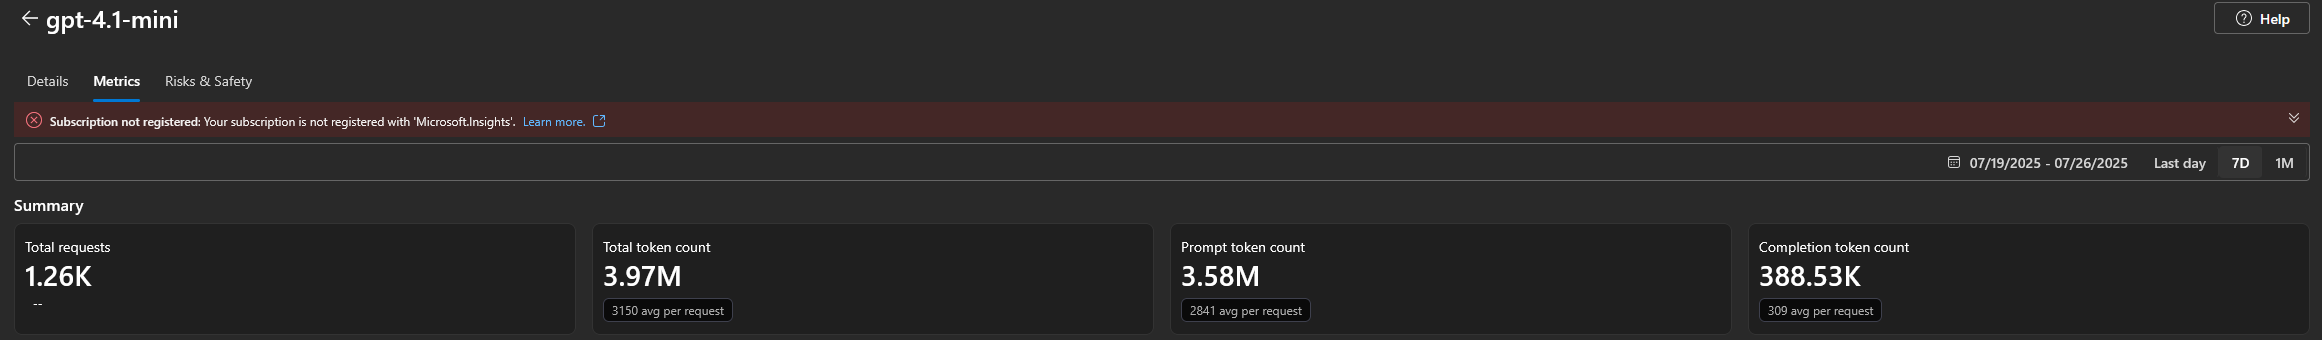

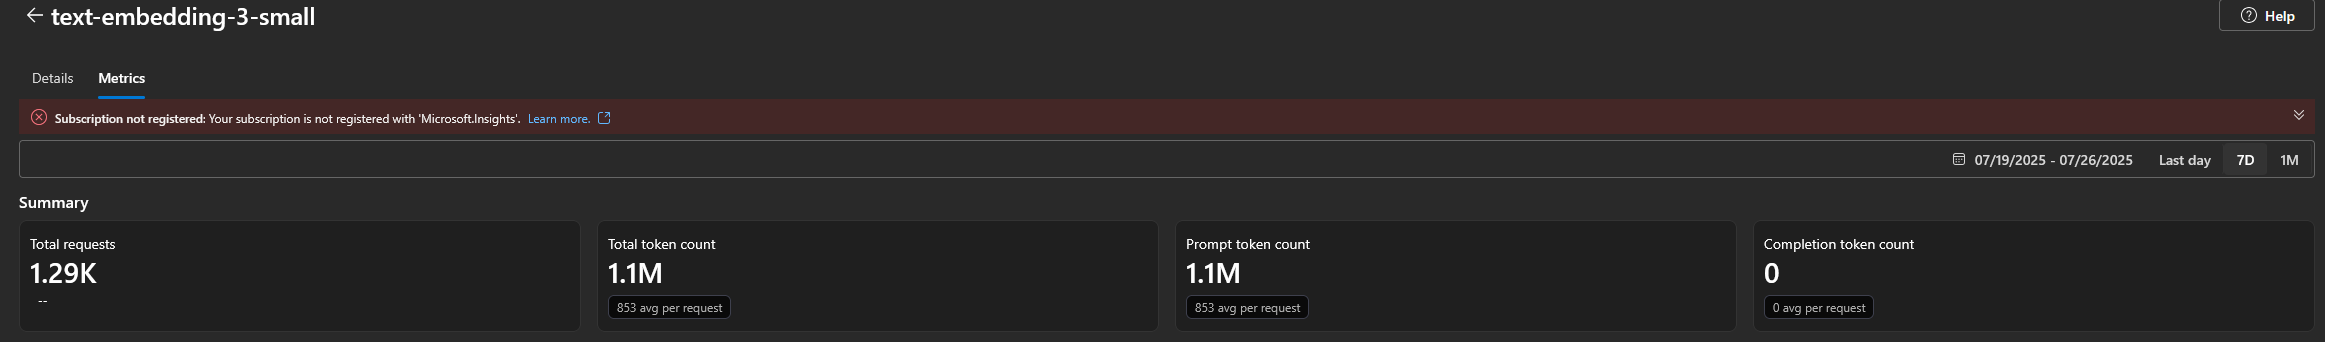

### Utana

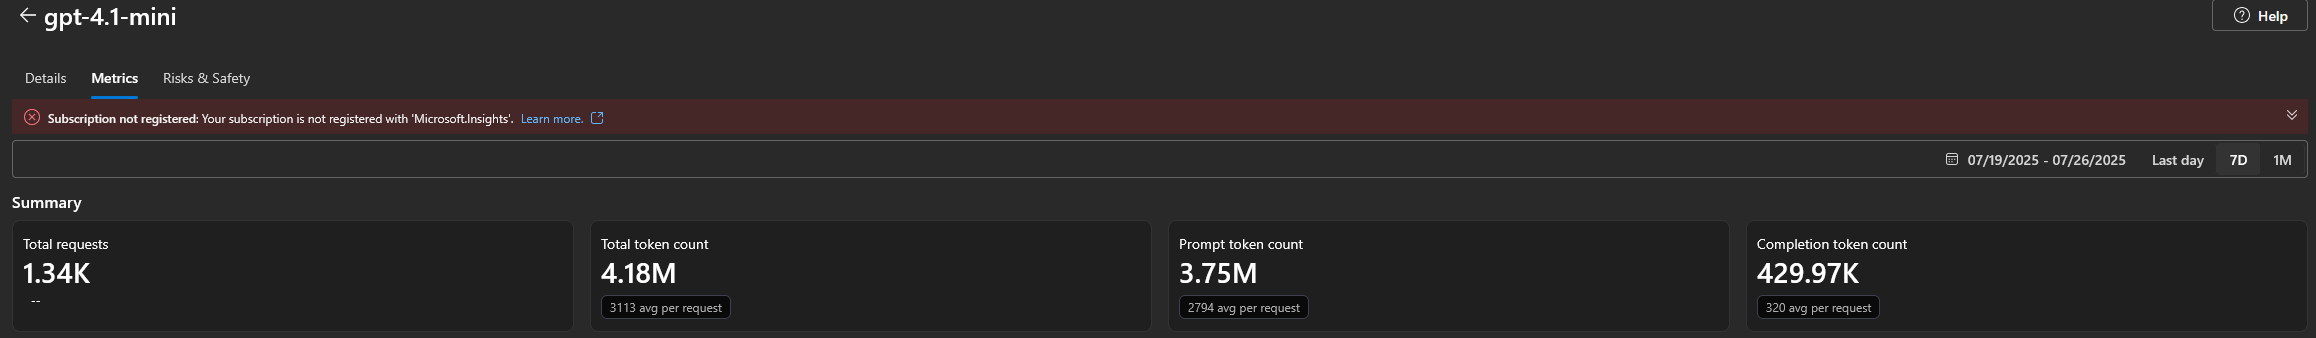

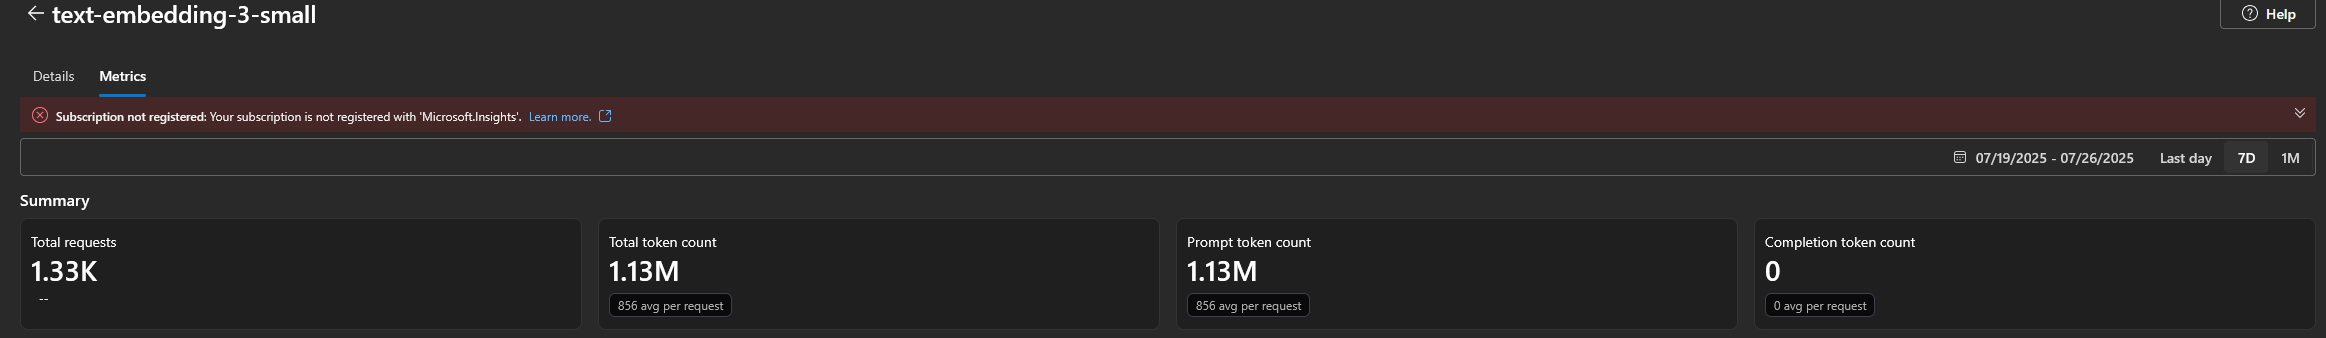

## Elokeszito kodok

In [ ]:
glob_context_builder = GlobalCommunityContext(
    community_reports=reports,
    communities=communities,
    entities=entities,  # default to None if you don't want to use community weights for ranking
    token_encoder=token_encoder,
)

In [ ]:
glob_context_builder_params = {
    "use_community_summary": False,  # False means using full community reports. True means using community short summaries.
    "shuffle_data": True,
    "include_community_rank": True,
    "min_community_rank": 0,
    "community_rank_name": "rank",
    "include_community_weight": True,
    "community_weight_name": "occurrence weight",
    "normalize_community_weight": True,
    "max_tokens": 16_000,  # change this based on the token limit you have on your model (if you are using a model with 8k limit, a good setting could be 5000)
    "context_name": "Reports",
}

glob_map_llm_params = {
    "max_tokens": 2000,
    "temperature": 0.0,
    "response_format": {"type": "json_object"},
}

glob_reduce_llm_params = {
    "max_tokens": 4000,  # change this based on the token limit you have on your model (if you are using a model with 8k limit, a good setting could be 1000-1500)
    "temperature": 0.0,
}

In [ ]:
glob_search_engine = GlobalSearch(
    model=chat_model,
    context_builder=glob_context_builder,
    token_encoder=token_encoder,
    max_data_tokens=16_000,  # change this based on the token limit you have on your model (if you are using a model with 8k limit, a good setting could be 5000)
    map_llm_params=glob_map_llm_params,
    reduce_llm_params=glob_reduce_llm_params,
    allow_general_knowledge=False,  # set this to True will add instruction to encourage the LLM to incorporate general knowledge in the response, which may increase hallucinations, but could be useful in some use cases.
    json_mode=True,  # set this to False if your LLM model does not support JSON mode.
    context_builder_params=glob_context_builder_params,
    concurrent_coroutines=16,
    response_type="multiple paragraphs",  # free form text describing the response type and format, can be anything, e.g. prioritized list, single paragraph, multiple paragraphs, multiple-page report
)

## GraphRAG Global search

In [ ]:
for question in questions:
    print('='*50)
    print(question)
    print('-'*50)
    result = await glob_search_engine.search(question)
    print(result.response)
    print(' '*50)

## Token hasznalat a notebook futtatasahoz

### Elotte

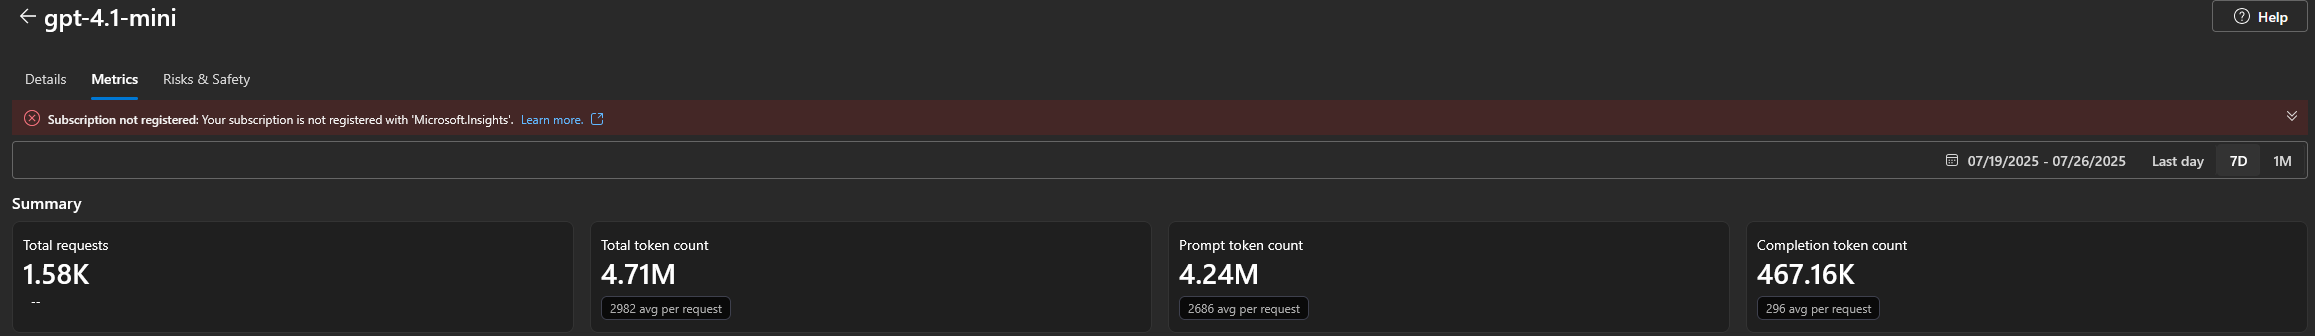

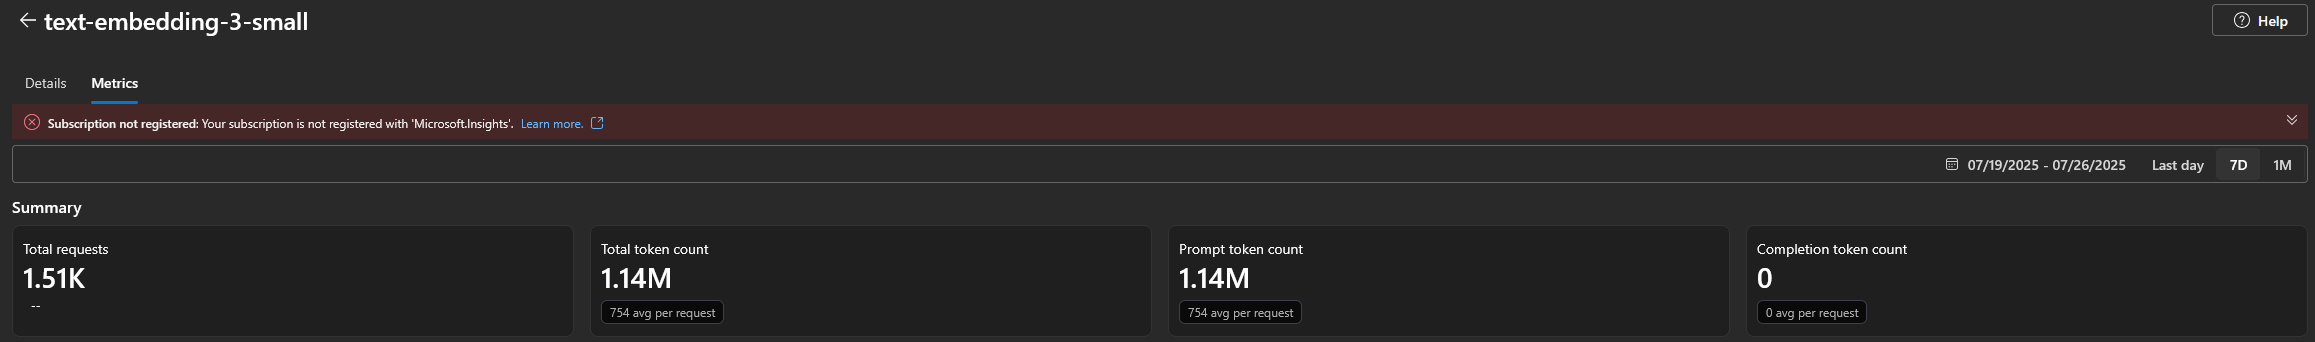

### Utana

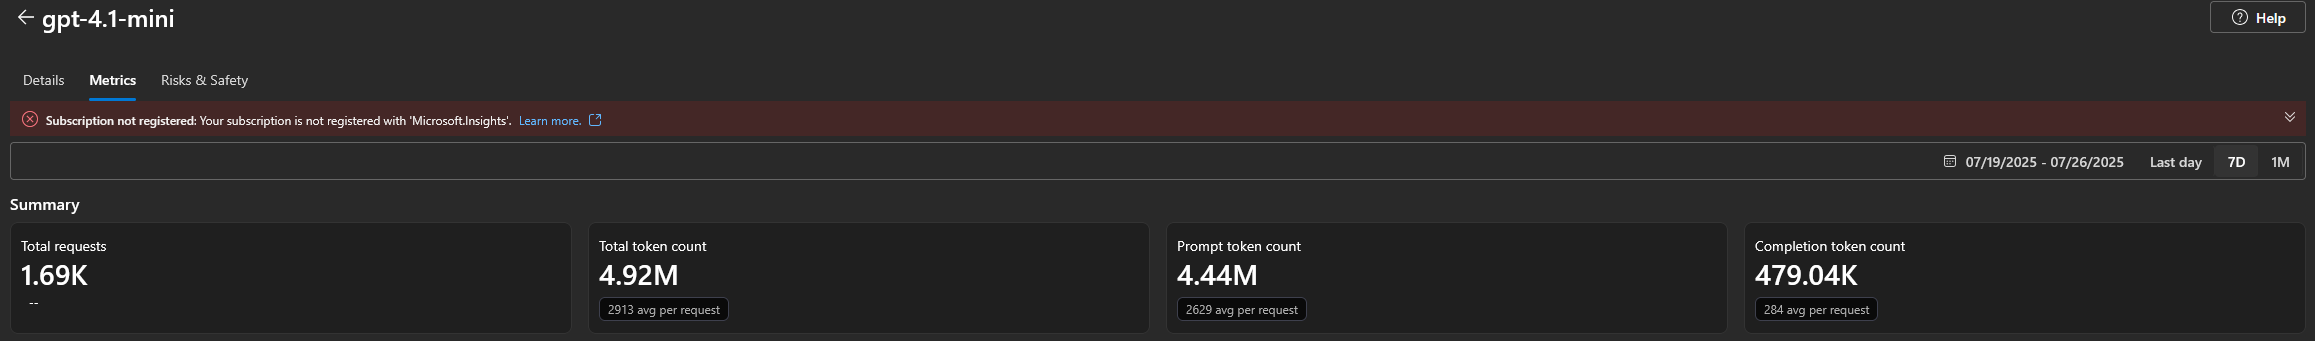

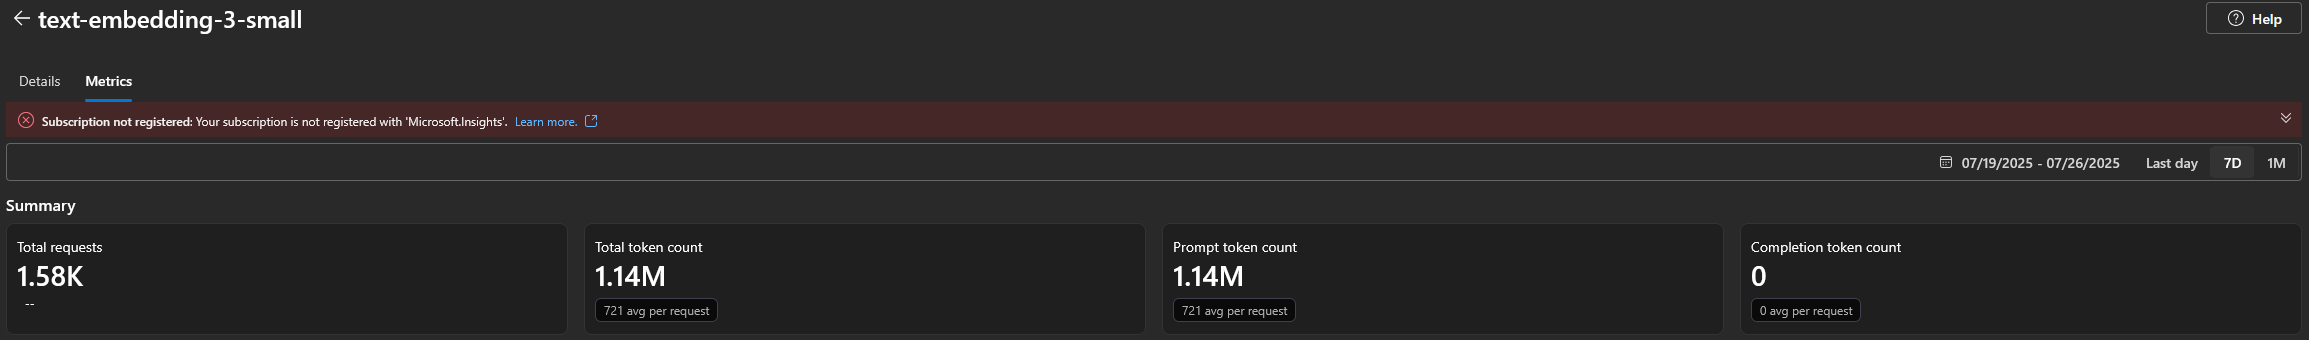

# FAISS

In [ ]:
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
import re
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core import Document

In [ ]:
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
def get_doc_nodes(text, chunk_size=300, chunk_overlap=50):
    sentence_splitter = SentenceSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )

    document = Document(text=text)
    nodes = sentence_splitter.get_nodes_from_documents([document])
    return nodes

In [ ]:
def get_chunks(file_path="./graphragtest/input/THE_GALLERY_OF_SECRETS.txt", chunk_size=300, chunk_overlap=50):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return []
    
    text = re.sub(r'\s+', ' ', text).strip()
    chunks = get_doc_nodes(text, chunk_size, chunk_overlap)
    return chunks

In [ ]:
def create_faiss_index_with_sentence_chunks(chunks):
    print(f"Creating embeddings for {len(chunks)} sentence-aware chunks...")
    
    chunk_texts = [chunk.text for chunk in chunks]
    embeddings = sentence_model.encode(chunk_texts, show_progress_bar=True)
    embeddings = np.array(embeddings).astype('float32')
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatIP(dimension)  # Inner product (cosine similarity)
    
    faiss.normalize_L2(embeddings)
    index.add(embeddings)
    
    print(f"FAISS index created with {index.ntotal} vectors of dimension {dimension}")
    return index, embeddings, chunk_texts

In [ ]:
def faiss_search_sentences(query, index, chunks, top_k=5):
    query_embedding = sentence_model.encode([query])
    query_embedding = np.array(query_embedding).astype('float32')
    faiss.normalize_L2(query_embedding)
    scores, indices = index.search(query_embedding, top_k)
    results = []
    for i, (score, idx) in enumerate(zip(scores[0], indices[0])):
        results.append({
            'chunk': chunks[idx],
            'score': float(score),
            'index': int(idx)
        })
    return results

In [ ]:
def faiss_rag_sentences(query, index, chunks, top_k=3):
    search_results = faiss_search_sentences(query, index, chunks, top_k)
    context_chunks = [result['chunk'] for result in search_results]
    context = "\n".join(context_chunks)
    return context

In [ ]:
print("Loading and chunking story with sentence awareness...")
sentence_chunks = get_chunks(chunk_size=300, chunk_overlap=50)

if sentence_chunks:
    print(f"Successfully loaded {len(sentence_chunks)} sentence-aware chunks")
    faiss_sentence_index, sentence_embeddings, processed_sentence_chunks = create_faiss_index_with_sentence_chunks(sentence_chunks)
    print("FAISS sentence-aware index ready for searching!")
else:
    print("Failed to load sentence chunks")

In [ ]:
for q in questions:
    context = faiss_rag_sentences(q, faiss_sentence_index, processed_sentence_chunks, top_k=10)
    print('='*50)
    print(q)
    print('-'*50)
    print(context)
    print('-'*50)
    print(get_chat_response(context, q))
    print('\n' + ' '*50 + '\n')